In [15]:
import pandas as pd
import numpy as np
from scipy.stats import mode, entropy
from datetime import datetime, timedelta
from collections import defaultdict
from pprint import pprint
import time, json, os

from sklearn.preprocessing import StandardScaler, MinMaxScaler, MaxAbsScaler, RobustScaler
from sklearn.utils import shuffle
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.svm import LinearSVC
from sklearn.metrics import confusion_matrix, fbeta_score, precision_score, recall_score, accuracy_score, roc_auc_score, average_precision_score
from sklearn.feature_selection import RFE

pd.set_option('display.max_columns', None)
os.chdir('/Users/meif/Desktop/SI 699')
import matplotlib.pyplot as plt

% matplotlib inline 

This notebook is to use Recursive Feature Elimination to do the feature selection.

## 0. Prepare Dataset

In [3]:
# continuous and categorical
mains = ["user_coupon", "user_id", "coupon_id", "start_time", "is_used"]

categorical = ['sex_1', 'sex_2', 
               'age_60', 'age_70', 'age_80', 'age_90', 'age_0', 
               'city1', 'city2', 'city3', 'city4', 'city5', 
               'AppVerLast_2.1', 'AppVerLast_2.2', 'AppVerLast_2.3', 'AppVerLast_2.4', 'AppVerLast_2.5', 'AppVerLast_2.7', 'AppVerLast_2.8',
               'covers_mon', 'covers_tue', 'covers_wed', 'covers_thu', 'covers_fri', 'covers_sat', 'covers_sun', 
               'type1', 'type6', 
               'Complaints', 'Eventsoperation', 'NewUserCouponPackageByBD', 'PreUserCouponCode', 'RecallUserDaily', 'home201603222253', 
               'home_dongbeiguan', 'home_jiangzhecai', 'home_muqinjie', 'home_xiangcaiguan', 'preuser', 'shareuser', 
               '商家拒单返券', '家厨发券', '活动赠券', '码兑券', '自运营赠券', '蒲公英受邀',
               'CoupUseLast']

conitnuous = ['kitchen_entropy', 
              'distance_median', 'distance_std',
              'user_longitude_median', 'user_longitude_std', 'user_latitude_median', 'user_latitude_std', 
              'coupon_effective_days', 'money', 'max_money', 
              'WeeklyCouponUsedCount', "BiWeeklyCouponUsedCount",
              'WeeklyOrderCount', 'BiWeeklyOrderCount',
              'coupon_usage_rate', 'order_coupon_usage_rate',
              'coupon_type1_usage_rate', 'coupon_type6_usage_rate',
              'coupon_used_weekend_perc', 'order_weekend_perc', 
              'worth_money_median', 'worth_money_std', 
              'InterCoup', 'InterOrder', 'Recency']

In [16]:
trainset = pd.read_csv("Dataset/trainset_180314.csv").iloc[:,1:]
testset = pd.read_csv("Dataset/testset_180314.csv").iloc[:,1:]
print(len(trainset) + len(testset))
print(trainset.columns[5:].tolist())

5484528
['sex_1', 'sex_2', 'age_60', 'age_70', 'age_80', 'age_90', 'age_0', 'city1', 'city2', 'city3', 'city4', 'city5', 'AppVerLast_2.1', 'AppVerLast_2.2', 'AppVerLast_2.3', 'AppVerLast_2.4', 'AppVerLast_2.5', 'AppVerLast_2.7', 'AppVerLast_2.8', 'kitchen_entropy', 'distance_median', 'distance_std', 'user_longitude_median', 'user_longitude_std', 'user_latitude_median', 'user_latitude_std', 'coupon_effective_days', 'money', 'max_money', 'covers_mon', 'covers_tue', 'covers_wed', 'covers_thu', 'covers_fri', 'covers_sat', 'covers_sun', 'type1', 'type6', 'Complaints', 'Eventsoperation', 'NewUserCouponPackageByBD', 'PreUserCouponCode', 'RecallUserDaily', 'home201603222253', 'home_dongbeiguan', 'home_jiangzhecai', 'home_muqinjie', 'home_xiangcaiguan', 'preuser', 'shareuser', '商家拒单返券', '家厨发券', '活动赠券', '码兑券', '自运营赠券', '蒲公英受邀', 'coupon_usage_rate', 'order_coupon_usage_rate', 'coupon_type1_usage_rate', 'coupon_type6_usage_rate', 'coupon_used_weekend_perc', 'order_weekend_perc', 'worth_money_media

In [19]:
len(testset) / 5484528

0.1936352590414344

In [5]:
# initialization: SCALER, MODEL, BALANCE, N_JOBS
SCALER = "3" # or 1, 2, 4
if SCALER == "1":
    scaler = MinMaxScaler()
elif SCALER == "2":
    scaler = StandardScaler()
elif SCALER == "3":
    scaler = MaxAbsScaler()
elif SCALER == "4":
    scaler = RobustScaler()

MODEL = "l2" # or l1, SVM
if MODEL == "l1":
    SOLVER = "saga"
    MAX_ITER = 1000
elif MODEL == "l2":
    SOLVER = "sag"
    MAX_ITER = 500
else:
    pass
    
BALANCE = 2
N_JOBS = 4

N_FEATURES = [5, 10, 25, 40, 72] # Keep top N features with large coefficientf
RANDOM_STATE = 42

In [6]:
# scaling
X_train_continuous = scaler.fit_transform(trainset[conitnuous])
X_test_continuous = scaler.transform(testset[conitnuous])

trainset_scaled = pd.concat([trainset.loc[:,mains + categorical], pd.DataFrame(X_train_continuous, columns = conitnuous)], axis=1)
testset_scaled = pd.concat([testset.loc[:,mains + categorical], pd.DataFrame(X_test_continuous, columns = conitnuous)], axis=1)

In [7]:
# split train & dev
split_date4 = "2016-05-06"

trainset4 = trainset_scaled[trainset_scaled["start_time"] <= split_date4]
devset4 = trainset_scaled[trainset_scaled["start_time"] > split_date4]

trainset4 = trainset4.iloc[shuffle(trainset4.index).tolist(),] # shuffle trainset

X_train = trainset4.iloc[:,5:]
y_train = trainset4["is_used"]
X_dev = devset4.iloc[:,5:]
y_dev = devset4["is_used"]

In [11]:
# train & test
trainset_all = trainset_scaled
trainset_all = trainset_all.iloc[shuffle(trainset_all.index).tolist(),]

X_train_all = trainset_all.iloc[:,5:]
y_train_all = trainset_all["is_used"]
X_test = testset_scaled.iloc[:,5:]
y_test = testset_scaled["is_used"]

## 1. Recursive Feature Elimination for Linear Models

In [12]:
X_train_all.columns

Index(['sex_1', 'sex_2', 'age_60', 'age_70', 'age_80', 'age_90', 'age_0',
       'city1', 'city2', 'city3', 'city4', 'city5', 'AppVerLast_2.1',
       'AppVerLast_2.2', 'AppVerLast_2.3', 'AppVerLast_2.4', 'AppVerLast_2.5',
       'AppVerLast_2.7', 'AppVerLast_2.8', 'covers_mon', 'covers_tue',
       'covers_wed', 'covers_thu', 'covers_fri', 'covers_sat', 'covers_sun',
       'type1', 'type6', 'Complaints', 'Eventsoperation',
       'NewUserCouponPackageByBD', 'PreUserCouponCode', 'RecallUserDaily',
       'home201603222253', 'home_dongbeiguan', 'home_jiangzhecai',
       'home_muqinjie', 'home_xiangcaiguan', 'preuser', 'shareuser', '商家拒单返券',
       '家厨发券', '活动赠券', '码兑券', '自运营赠券', '蒲公英受邀', 'CoupUseLast',
       'kitchen_entropy', 'distance_median', 'distance_std',
       'user_longitude_median', 'user_longitude_std', 'user_latitude_median',
       'user_latitude_std', 'coupon_effective_days', 'money', 'max_money',
       'WeeklyCouponUsedCount', 'BiWeeklyCouponUsedCount', 'WeeklyOrderCo

In [13]:
selected_linear = defaultdict(lambda: defaultdict(lambda: defaultdict(lambda: list)))
selected_linear["MODEL"] = MODEL
selected_linear["SCALER"] = SCALER
selected_linear["BALANCE"] = BALANCE

for f in N_FEATURES:
    selected_linear["RANKING"][str(f)] = []
    selected_linear["SELECTED"][str(f)] = []
selected_linear

defaultdict(<function __main__.<lambda>>,
            {'BALANCE': 2,
             'MODEL': 'l2',
             'RANKING': defaultdict(<function __main__.<lambda>.<locals>.<lambda>>,
                         {'10': [], '25': [], '40': [], '5': [], '72': []}),
             'SCALER': '3',
             'SELECTED': defaultdict(<function __main__.<lambda>.<locals>.<lambda>>,
                         {'10': [], '25': [], '40': [], '5': [], '72': []})})

In [ ]:
# train
start_time = time.time()

for f in N_FEATURES:
    start_time2 = time.time()
        
    if MODEL in ["l1", "l2"]:
        lr = LogisticRegression(C=1, 
                                penalty=MODEL, solver=SOLVER, 
                                class_weight={1: BALANCE}, 
                                max_iter=MAX_ITER,
                                random_state=RANDOM_STATE, n_jobs=N_JOBS)
        rfe = RFE(lr, 
                  n_features_to_select=f, step=1)
    else:
        svc = LinearSVC(C=1, 
                        class_weight={1: BALANCE},
                        random_state=RANDOM_STATE)
        rfe = RFE(svc, 
                  n_features_to_select=f, step=1)
            
    print("fitting rfe")
    rfe.fit(X_train, y_train)
    ranking = rfe.ranking_
    selected = X_train_all.columns[rfe.support_] 

    print("M: {}, F: {}".format(MODEL, f))
    print("SELECTED: {}\n".format(selected))
    selected_linear["RANKING"][str(f)] = str(ranking)
    selected_linear["SELECTED"][str(f)] = str(selected)
            
    print("Finished f {} in {} sec\n".format(f, time.time() - start_time2))
        
print("{} sec\n".format(time.time() - start_time))

In [17]:
# save param output
with open('ParamResults/LinearModels/other/selected_linear_{}_{}_1v{}.json'.format(MODEL, SCALER, BALANCE), 'w') as f:
    json.dump(selected_linear, f)

# 2. Evaluation

In [3]:
# load params
res_lr_l1_minmax_1v2 = json.load(open("ParamResults/res_lr_l1_1_1v2.json"))
res_lr_l1_maxabs_1v2 = json.load(open("ParamResults/res_lr_l1_3_1v2.json"))
res_lr_l2_minmax_1v2 = json.load(open("ParamResults/res_lr_l2_1_1v2.json"))
res_lr_l2_maxabs_1v2 = json.load(open("ParamResults/res_lr_l2_3_1v2.json"))
res_svm_linear_minmax_1v2 = json.load(open("ParamResults/res_svm_linear_1_1v2.json"))
res_svm_linear_maxabs_1v2 = json.load(open("ParamResults/res_svm_linear_3_1v2.json"))
# pprint(res_lr_l2_minmax_1v2)

evaluations = ["F05", "Precision", "Recall", "Mean_Pre", "AUC", "Accuracy"]
l1_c = ["0.01", "0.05", "0.1", "0.5", "1"]
l2_c = ["0.01", "0.1", "1", "10", "100"]
svm_c = ["0.01", "0.1", "1", "10", "100"]

plot_lr_l1_minmax_1v2 = {ev: [res_lr_l1_minmax_1v2[ev][c] for c in l1_c] for ev in evaluations}
plot_lr_l1_maxabs_1v2 = {ev: [res_lr_l1_maxabs_1v2[ev][c] for c in l1_c] for ev in evaluations}

plot_lr_l2_minmax_1v2 = {ev: [res_lr_l2_minmax_1v2[ev][c] for c in l2_c] for ev in evaluations}
plot_lr_l2_maxabs_1v2 = {ev: [res_lr_l2_maxabs_1v2[ev][c] for c in l2_c] for ev in evaluations}

plot_svm_linear_minmax_1v2 = {ev: [res_svm_linear_minmax_1v2[ev][c]["0"] for c in svm_c] for ev in evaluations}
plot_svm_linear_minmax_1v2 = {ev: [res_svm_linear_maxabs_1v2[ev][c]["0"] for c in svm_c] for ev in evaluations}

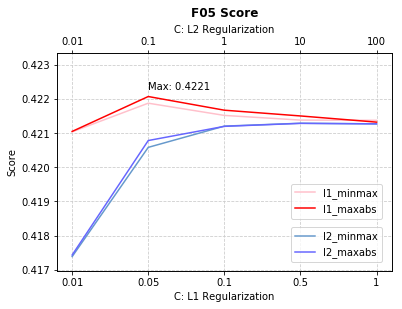

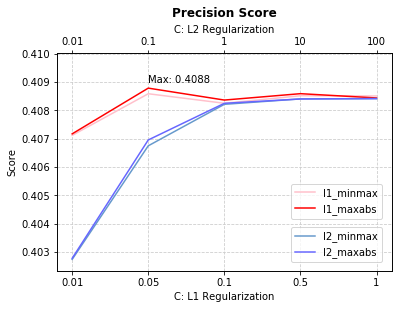

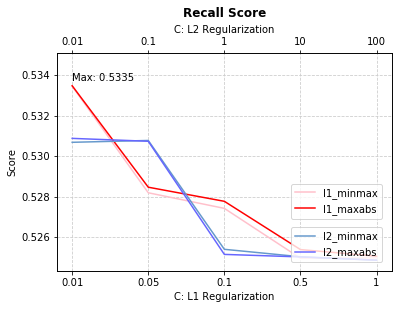

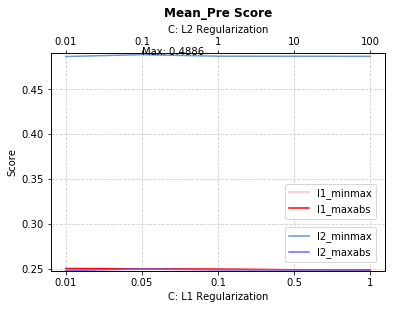

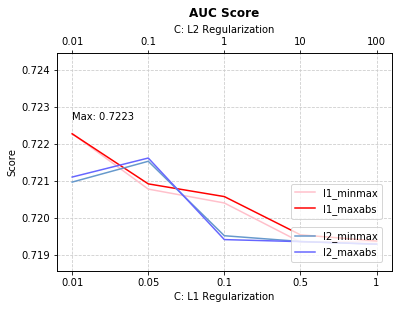

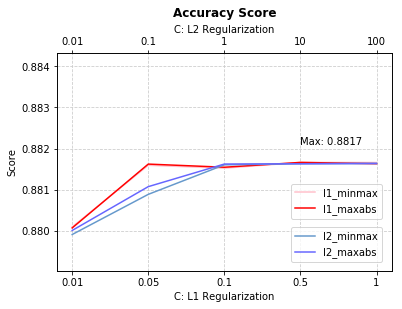

In [6]:
# plot
for i in range(len(evaluations)):
    fig = plt.figure(i + 1)
    
    plt.title(evaluations[i] + " Score", y=1.14, fontweight="bold")
    plt.grid(True, linestyle='--', color='#CCCCCC')
    
    ax1 = fig.add_subplot(111)
    ax2 = ax1.twiny()
    
    ax1_1 = plot_lr_l1_minma_1v2x[evaluations[i]]
    ax1_2 = plot_lr_l1_maxabs_1v2[evaluations[i]]
    ax2_1 = plot_lr_l2_minmax_1v2[evaluations[i]]
    ax2_2 = plot_lr_l2_maxabs_1v2[evaluations[i]]
    ax2_3 = plot_svm_linear_minmax_1v2[evaluations[i]]
    ax2_4 = plot_svm_linear_minmax_1v2[evaluations[i]]
    maxIdx = np.argmax(np.array(ax1_1+ax1_2+ax2_1+ax2_2+ax2_3+ax2_4))
    maxScore = max(ax1_1+ax1_2+ax2_1+ax2_2+ax2_3+ax2_4)
    minScore = min(ax1_1+ax1_2+ax2_1+ax2_2+ax2_3+ax2_4)
    
    ax1.set_ylabel('Score')
    ax1.set_xlabel('C: L1 Regularization')
    ax1.set_ylim(minScore*0.999, maxScore*1.003)
    ax1.set_xticks(range(5))
    ax1.set_xticklabels(l1_c)
    ax1.plot(ax1_1, label="l1_minmax_1v2", color='pink')
    ax1.plot(ax1_2, label="l1_maxabs_1v2", color='red')
    ax1.legend(bbox_to_anchor=(0.7, 0.4), loc=2, borderaxespad=0.)

    ax2.set_xlabel('C: L2 Regularization, LinearSVM')
    ax2.set_xticks(range(5))
    ax2.set_xticklabels(l2_c)
    ax2.plot(ax2_1, label="lr_l2_minmax_1v2", color='#6699CC')
    ax2.plot(ax2_2, label="lr_l2_maxabs_1v2", color='#6666FF')
    ax2.plot(ax2_3, label="svm_linear_minmax_1v2", color='#67E667')
    ax2.plot(ax2_4, label="svm_linear_maxabs_1v2", color='#008500')
    ax2.legend(bbox_to_anchor=(0.7, 0.2), loc=2, borderaxespad=0.)

    plt.annotate('Max: {0:.4f}'.format(maxScore), 
                 xy=(maxIdx%5, maxScore), 
                 xytext=(maxIdx%5, maxScore*1.0005))

    plt.savefig('LinearModels_{}.png'.format(evaluations[i]))
    plt.show()

In [ ]:
# retrain using selected params
c, p, s, b, mi, rs, nj = 0.05, 'l1', 'liblinear', 2, 1000, 42, 4
lr_best = LogisticRegression(C=c,
                             penalty=p, solver=s, 
                             class_weight={1: b}, 
                             max_iter=mi,
                             random_state=rs, n_jobs=nj)
lr_best.fit(X_train_all, y_train_all)

In [ ]:
# attributes
lr_best.coef_

In [2]:
# predict
y_pred = lr_best.predict(X_test)
print(confusion_matrix(y_test, y_pred, labels=[1,0]))
print("F05: {}".format(fbeta_score(y_test, y_pred, beta=0.5, labels=[1,0])))
print("Precision: {}".format(precision_score(y_test, y_pred, labels=[1,0])))
print("Recall: {}".format(recall_score(y_test, y_pred, labels=[1,0])))
print("Accuracy: {}".format(accuracy_score(y_test, y_pred)))